In [1]:
import requests
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import warnings
import matplotlib.patches as mpatches

warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

/Users/helenarusso/opt/miniconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
#let's download and import the feature table directly from the FBMN job in GNPS2
task_id = 'cff8c1a5895b4b9b917c36ad9444c635'
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

#import the metadata
metadata = pd.read_csv('/.../metadata_hCom_1_15052024.csv', sep=',')
column_interest = 'ATTRIBUTE_type' #this is the column in the metadata table we will work with

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#import library matches to N-acyl lipids massQL library
library_matches = pd.read_csv('https://gnps2.org/resultfile?task=' + task_id + '&file=nf_output/library/merged_results_with_gnps.tsv', sep='\t')
    
#create another column with simplified annotations:
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name'].str.split('(').str[0]
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name_simplified'].str.replace('Candidate ', '', regex=True)

#create a new column with the scans with a prefix
prefix = 'MS_'
library_matches['MS_#Scan#'] = library_matches['#Scan#'].apply(lambda x: f'{prefix}{x}')

File saved at /Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Examples_lipids/


In [3]:
### BLANK SUBTRACTION

#drop columns that are not of interest for blank subtraction
prefixes = ('sixmix', 'ACN_', 'pool_', 'TCA.', 'TCDCA.mzML', 'TDCA.mzML', 'three_alpha', 'TLCA.mzML')
columns_to_drop = [col for col in ftable.columns if col.startswith(prefixes)]
ftable = ftable.drop(columns=columns_to_drop)

#remove the rows that are all zero after dropping these columns
# Set 'row ID' as the index
ftable.set_index('row ID', inplace=True)
# Remove rows where all values are zero
ftable = ftable.loc[~(ftable == 0).all(axis=1)]
# Reset the index if needed
ftable.reset_index(inplace=True)

# define a string that will define the Blank analyses you want to subtract
blank_string = 'lank'
core_columns = ['row ID']

#get the columns that have blank_string and create a dataframe
blank_columns = [col for col in ftable.columns if blank_string in col]
df_blanks = ftable[core_columns + blank_columns]

#and the ones that don't and create a new dataframe
df_samples = ftable[core_columns + [col for col in ftable.columns if col not in core_columns + blank_columns]]

# calculate the average in blanks and average in samples of each feature

# blanks
non_core_columns_blanks = [col for col in df_blanks.columns if col not in core_columns]
df_blanks['blank_average'] = df_blanks[non_core_columns_blanks].mean(axis=1)

#samples
non_core_columns_samples = [col for col in df_samples.columns if col not in core_columns]
df_samples['sample_average'] = df_samples[non_core_columns_samples].mean(axis=1)

#create a new dataset with the averages and compare the fold change in each average. 
#if the feature is in less than 3x higher in samples, it will be removed.
df_averages = df_samples[['row ID', 'sample_average']]
df_averages = pd.merge(df_averages, df_blanks[['row ID', 'blank_average']], on='row ID', how='left')

# Check if sample_average is at least 3 times greater than blank_average
fold_change = 3

df_averages['comment'] = df_averages.apply(
    lambda row: "keep" if row['sample_average'] >= fold_change * row['blank_average'] else "remove", axis=1
)

features_to_keep = df_averages[df_averages['comment'] == 'keep']
features_to_keep = features_to_keep['row ID'].tolist()

#filter the original dataframe
ftable = ftable[ftable['row ID'].isin(features_to_keep)]


In [4]:
#filter down the feature table to only have the features that matched the massQL library
list_matches = library_matches['#Scan#'].to_list()
ftable_filtered = ftable[ftable['row ID'].isin(list_matches)]

# formatting table for box plots
ftable_filtered = ftable_filtered.T
ftable_filtered = ftable_filtered.reset_index()
ftable_filtered.columns = ftable_filtered.iloc[0]
ftable_filtered = ftable_filtered[1:]
ftable_filtered = ftable_filtered.add_prefix(prefix)
ftable_filtered = ftable_filtered.rename(columns={'MS_row ID': 'filename'})
ftable_filtered.head()

#remove .mzML/.mzXML from metadata file and ftable
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzML', '') if x.endswith('.mzML') else x)
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzXML', '') if x.endswith('.mzXML') else x)

ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzML Peak area', '') if x.endswith('.mzML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzXML Peak area', '') if x.endswith('.mzXML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('_rerun', '') if x.endswith('_rerun') else x)

#merge and reorganize
ftable_filtered_merged = pd.merge(ftable_filtered, metadata[['filename', column_interest]], 
                                  on='filename', how='left')

# keep samples and media only
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged[column_interest].isin(['sample','medium'])]

ftable_filtered_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_filtered_merged.columns]
ftable_filtered_merged = ftable_filtered_merged.drop(column_interest, axis=1)


In [5]:
### calculate average in media and in each organism

#get the mean of each feature considering all the media

rows_to_average = [
    'media_mPYG_BHI_1',
    'media_mPYG_BHI_2',
    'media_mPYG_BHI_3',
    'medium_mPYG_1',
    'medium_mPYG_2',
    'medium_mPYG_3',
    'medium_mPYG_4',
    'medium_mPYG_5'
]

# Filter the DataFrame to include only the specified rows
df_filtered = ftable_filtered_merged[ftable_filtered_merged['filename'].isin(rows_to_average)]

# Calculate the mean for each column (excluding the 'filename' column)
mean_row = df_filtered.drop(columns=['filename']).median(axis=0)

# Convert the mean row to a DataFrame and add the 'filename' column
mean_row_df = pd.DataFrame([mean_row])
mean_row_df['filename'] = 'medium_median'

# Append the mean row to the original DataFrame
ftable_filtered_merged = pd.concat([ftable_filtered_merged, mean_row_df], ignore_index=True)
ftable_filtered_merged = ftable_filtered_merged[~ftable_filtered_merged['filename'].isin(rows_to_average)]
ms_columns = [col for col in ftable_filtered_merged.columns if col.startswith('MS_')]
filtered_data = ftable_filtered_merged[['filename'] + ms_columns]
filtered_data['filename'] = filtered_data['filename'].apply(lambda x: '_'.join(x.split('_')[:-1]))
filtered_data = filtered_data.sort_values(by='filename', ascending=True)


In [6]:
#reorganize the column order
metadata = pd.read_csv('/.../deltas_annotation_reordered.txt', sep='\t')
metadata['order'] = metadata['order'].astype(str).str.zfill(3)
ms_features = pd.DataFrame(filtered_data.columns[1:], columns=['MS_#Scan#'])
ms_features = pd.merge(ms_features, library_matches[['MS_#Scan#', 'Compound_Name_simplified']], 
                       on='MS_#Scan#', how='left')
ms_features['annotation'] = ms_features['Compound_Name_simplified'].str.split('-').str[-1]
ms_features['annotation'] = ms_features['annotation'].str.replace(' ','')
ms_features = pd.merge(ms_features, metadata[['annotation','order']], on='annotation', how='left')
ms_features['order'] = ms_features['order'].astype(str) + '_'+ ms_features['Compound_Name_simplified'].str.split('-').str[0]
ms_features_reordered = ms_features.sort_values(by='order', ascending=True)
ordered_feature_names = ms_features_reordered['MS_#Scan#'].tolist()


In [7]:
# Additional filter

# Extract the microbial identifier (without replicate part)
filtered_data['microbe'] = filtered_data['filename'].apply(lambda x: '_'.join(x.split('_')[:-1]))

# Group by microbial identifier
grouped = filtered_data.groupby('microbe')

# Create a copy of the DataFrame to modify
df_updated = filtered_data.copy()

# Filter out groups with only one replicate
df_filtered = filtered_data[filtered_data['microbe'].map(filtered_data['microbe'].value_counts()) > 1]

# Update the group with df_filtered
grouped = df_filtered.groupby('microbe')

#1) only keep the ones in which the features were detected in both replicates

for name, group in grouped:
    # Get the indices of the rows in the group
    indices = group.index
    
    # Check for zero values in the group
    zero_mask = (group.drop(columns=['filename', 'microbe']) == 0).any(axis=0)
    
    # If there are any zero values, set corresponding values in all replicates to zero
    if zero_mask.any():
        for col in zero_mask.index:
            if zero_mask[col]:
                df_updated.loc[indices, col] = 0
                

In [8]:
#calculate log2 fold change

# Add a small constant to avoid division by zero or log of zero
epsilon = 1e-1
filtered_data[ms_columns] += epsilon

groups = ['medium'] + [b for b in filtered_data['filename'].unique() if b not in ['medium']]

# Calculate the median for each group
median_data = filtered_data[filtered_data['filename'].isin(groups)].groupby('filename').median()

# Identify the media row
media_row = median_data.loc['medium']

# Divide each column by the corresponding GF value
df_divided_by_media = median_data.apply(lambda x: x / media_row, axis=1)

# Calculate the log2(fold change) compared to GF
log2_fold_change = df_divided_by_media.applymap(np.log2)

# Drop the GF row as its log2 fold change with itself is NaN
# log2_fold_change = log2_fold_change.drop('medium')
log2_fold_change = log2_fold_change.reset_index()


In [9]:
df_pivoted = log2_fold_change.set_index('filename').transpose()
df_pivoted.to_csv('/Users/helenarusso/Downloads/table.tsv', sep='\t')
df_pivoted = pd.read_csv('/Users/helenarusso/Downloads/table.tsv', sep='\t')
df_pivoted = df_pivoted.rename(columns={'Unnamed: 0': 'MS_#Scan#'})
df_pivoted = pd.merge(df_pivoted, ms_features_reordered[['MS_#Scan#', 'Compound_Name_simplified', 'order']],
                     on='MS_#Scan#', how='left')
df_pivoted = df_pivoted.sort_values(by='order', ascending=True)
df_pivoted = df_pivoted.set_index('Compound_Name_simplified')
df_pivoted = df_pivoted.drop(['MS_#Scan#','order'], axis=1)

# Desired order for the first few columns
desired_order = ['medium']

# Get the remaining columns and sort them alphabetically
remaining_columns = sorted([col for col in df_pivoted.columns if col not in desired_order])

# Combine the desired order with the sorted remaining columns
new_order = desired_order + remaining_columns

# Reorder the columns of the DataFrame
df_pivoted = df_pivoted[new_order]


# Organize microbes by NCBI taxonomy

In [10]:
from ete3 import NCBITaxa, TreeStyle, TextFace

#import the dataframe with the NCBI taxonomy IDs of each microbe in this study
df = pd.read_csv('/.../microbes_ncbi_monocultures.txt', sep='\t')

# Initialize NCBITaxa instance
ncbi = NCBITaxa()

# Function to get the taxonomic tree
def get_taxonomic_tree(taxonomy_ids):
    tree = ncbi.get_topology(taxonomy_ids)
    return tree

# Function to get the taxonomic class for each taxonomy ID
def get_taxonomic_classes(taxonomy_ids):
    lineage_dict = ncbi.get_lineage_translator(taxonomy_ids)
    tax2name = ncbi.get_taxid_translator([item for sublist in lineage_dict.values() for item in sublist])
    classes = {}
    for taxid, lineage in lineage_dict.items():
        class_name = None
        for ancestor in lineage:
            rank = ncbi.get_rank([ancestor])[ancestor]
            if rank == 'class':
                class_name = tax2name[ancestor]
                break
        classes[taxid] = class_name
    return classes

# Extract Taxonomy_IDs and strain names from the DataFrame
taxonomy_ids = df['Taxonomy_IDs_species'].tolist()
strain_names = df.set_index('Taxonomy_IDs_species')['strain'].to_dict()

# Get the taxonomic classes
taxonomic_classes = get_taxonomic_classes(taxonomy_ids)

# Get the taxonomic tree
tree = get_taxonomic_tree(taxonomy_ids)

# Add names and classes to the tree using the names from the original DataFrame
for leaf in tree.iter_leaves():
    taxid = int(leaf.name)
    if taxid in strain_names:
        class_name = taxonomic_classes.get(taxid, '')
        leaf.name = f"{strain_names[taxid]} ({class_name})"
#         leaf.name = f"{strain_names[taxid]}"

# Customize TreeStyle
ts = TreeStyle()
ts.show_leaf_name = False

# Render the tree
# tree.show(tree_style=ts)

# output_path = '/.../taxonomic_tree.pdf'
# tree.render(output_path, tree_style=ts)

# Function to get a list of organisms from top to bottom in the tree
def get_organisms_list(tree):
    return [leaf.name for leaf in tree.iter_leaves()]

# Get the list of organisms from top to bottom and print
organisms_list = get_organisms_list(tree)
for organism in organisms_list:
    print(organism)
    

Clostridium_hathewayi_DSM_13479 (Clostridia)
Clostridium_sp_M62_1 (Clostridia)
Ruminococcus_gnavus_ATCC_29149 (Clostridia)
Ruminococcus_torques_ATCC_27756 (Clostridia)
Ruminococcus_lactaris_ATCC_29176 (Clostridia)
Coprococcus_eutactus_ATCC_27759 (Clostridia)
Coprococcus_comes_ATCC_27758 (Clostridia)
Clostridium_scindens_ATCC_35704 (Clostridia)
Clostridium_hylemonae_DSM_15053 (Clostridia)
Blautia_hansenii_DSM_20583 (Clostridia)
Blautia_hydrogenotrophica_DSM_10507 (Clostridia)
Clostridium_asparagiforme_DSM_15981 (Clostridia)
Clostridium_bolteae_ATCC_BAA-613 (Clostridia)
Dorea_formicigenerans_ATCC_27755 (Clostridia)
Dorea_longicatena_DSM_13814 (Clostridia)
Butyrivibrio_crossotus_DSM_2876 (Clostridia)
Clostridium_nexile_DSM_1787 (Clostridia)
Eubacterium_eligens_ATCC_27750 (Clostridia)
Bryantella_formatexigens_DSM_14469 (Clostridia)
Clostridium_saccharolyticum_WM1 (Clostridia)
Eubacterium_hallii_DSM_3353 (Clostridia)
Eubacterium_rectale_ATCC_33656 (Clostridia)
Roseburia_inulinivorans_DSM_16

In [11]:
microbe_order = ['Clostridium_hathewayi_DSM_13479', 'Clostridium_sp_M62_1', 'Ruminococcus_gnavus_ATCC_29149',
                 'Ruminococcus_torques_ATCC_27756', 'Ruminococcus_lactaris_ATCC_29176', 'Coprococcus_eutactus_ATCC_27759',
                 'Coprococcus_comes_ATCC_27758', 'Clostridium_scindens_ATCC_35704', 'Clostridium_hylemonae_DSM_15053',
                 'Blautia_hansenii_DSM_20583', 'Blautia_hydrogenotrophica_DSM_10507', 'Clostridium_asparagiforme_DSM_15981',
                 'Clostridium_bolteae_ATCC_BAA-613','Dorea_formicigenerans_ATCC_27755','Dorea_longicatena_DSM_13814',
                 'Butyrivibrio_crossotus_DSM_2876','Clostridium_nexile_DSM_1787','Eubacterium_eligens_ATCC_27750',
                 'Bryantella_formatexigens_DSM_14469','Clostridium_saccharolyticum_WM1','Eubacterium_hallii_DSM_3353',
                 'Eubacterium_rectale_ATCC_33656','Roseburia_inulinivorans_DSM_16841','Anaerostipes_caccae_DSM_14662',
                 'Clostridium_methylpentosum_DSM_5476','Clostridium_leptum_DSM_753','Ruminococcus_gauvreauii_DSM_19829',
                 'Oscillibacter_sp_KLE_1728','Anaerotruncus_colihominis_DSM_17241','Bacteroides_pectinophilus_ATCC_43243',
                 'Intestinimonas_butyriciproducens_DSM_26588','Eubacterium_ventriosum_ATCC_27560',
                 'Catenibacterium_mitsuokai_DSM_15897','Clostridium_spiroforme_DSM_1552',
                 'Holdemania_filiformis_DSM_12042','Granulicatella_adiacens_ATCC_49175',
                 'Lactobacillus_ruminis_ATCC_25644','Acidaminococcus_fermentans_DSM_20731',
                 'Acidaminococcus_intestini_sp_D21','Collinsella_stercoris_DSM_13279','Collinsella_aerofaciens_ATCC_25986',
                 'Bifidobacterium_breve_DSM_20213','Bifidobacterium_catenulatum_DSM_16992','Bifidobacterium_pseudocatenulatum_DSM_20438',
                 'Bacteroides_cellulosilyticus_DSM_14838','Bacteroides_finegoldii_DSM_17565','Bacteroides_xylanisolvens_DSMZ_18836',
                 'Bacteroides_stercoris_ATCC_43183','Bacteroides_fragilis_3_1_12','Bacteroides_thetaiotaomicron_VPI-5482',
                 'Bacteroides_uniformis_ATCC_8492','Bacteroides_caccae_ATCC_43185','Bacteroides_eggerthii_DSM_20697',
                 'Bacteroides_sp_D2','Bacteroides_ovatus_ATCC_8483','Bacteroides_rodentium_DSM_26882',
                 'Bacteroides_intestinalis_DSM_17393','Bacteroides_plebeius_DSM_17135','Bacteroides_dorei_5_1_36_D4',
                 'Bacteroides_vulgatus_ATCC_8482','Butyricimonas_virosa_DSM_23226','Odoribacter_splanchnicus_DSM_20712',
                 'Prevotella_buccae_D17','Prevotella_buccalis_ATCC_35310','Parabacteroides_merdae_ATCC_43184',
                 'Parabacteroides_sp_D13','Parabacteroides_distasonis_ATCC_8503','Parabacteroides_johnsonii_DSM_18315',
                 'Alistipes_finegoldii_DSM_17242','Alistipes_putredinis_DSM_17216','Akkermansia_muciniphila_ATCC_BAA-835']

df_pivoted = df_pivoted[microbe_order]
df_pivoted.columns = df_pivoted.columns.str.replace('_', ' ')


In [12]:
# Define the colors for the colormap
colors = [
    (0.0, '#4575b4'),  # Low values
    (0.5, 'white'),   # Middle value
    (1.0, '#d73027')   # High values
]

# Create the colormap
divergent_cmap = LinearSegmentedColormap.from_list('divergent_cmap', colors)

In [13]:
# import dataframe with microbial classes for color bar
microbial_classes = pd.read_csv('/.../Monocultures_Vince_microbial_class_df.txt', sep='\t')

# Ensure microbial_classes is indexed by the microbe names
microbial_classes.set_index('microbe', inplace=True)

#get the unique microbial classes
unique_classes = microbial_classes['class'].unique()

# Reorder the columns of df_combined_sorted to match the order in microbial_classes
df_pivoted = df_pivoted[microbial_classes.index]

# Define a dictionary with specific colors for each microbial class
class_color_mapping = {
    'None': 'black',
    'Bacilli': '#1f77b4',
    'Clostridia': '#aec7e8',
    'Erysipelotrichia': '#ff7f0e',
    'Tissierellia': '#ffbb78',
    'Actinomycetes': 'forestgreen',
    'Coriobacteriia': 'lightgray',
    'Gammaproteobacteria': 'darkturquoise',
    'Betaproteobacteria': 'paleturquoise',
    'Bacteroidia': '#9467bd',
    'Epsilonproteobacteria': '#c5b0d5',
    'Fusobacteriia': '#8c564b',
    'Verrucomicrobiae': '#c49c94',
    'Negativicutes': 'pink'
    # Add more classes and their specific colors as needed
}

# Map the classes to colors using the predefined dictionary
col_colors = microbial_classes['class'].map(class_color_mapping)


<Figure size 1080x864 with 0 Axes>

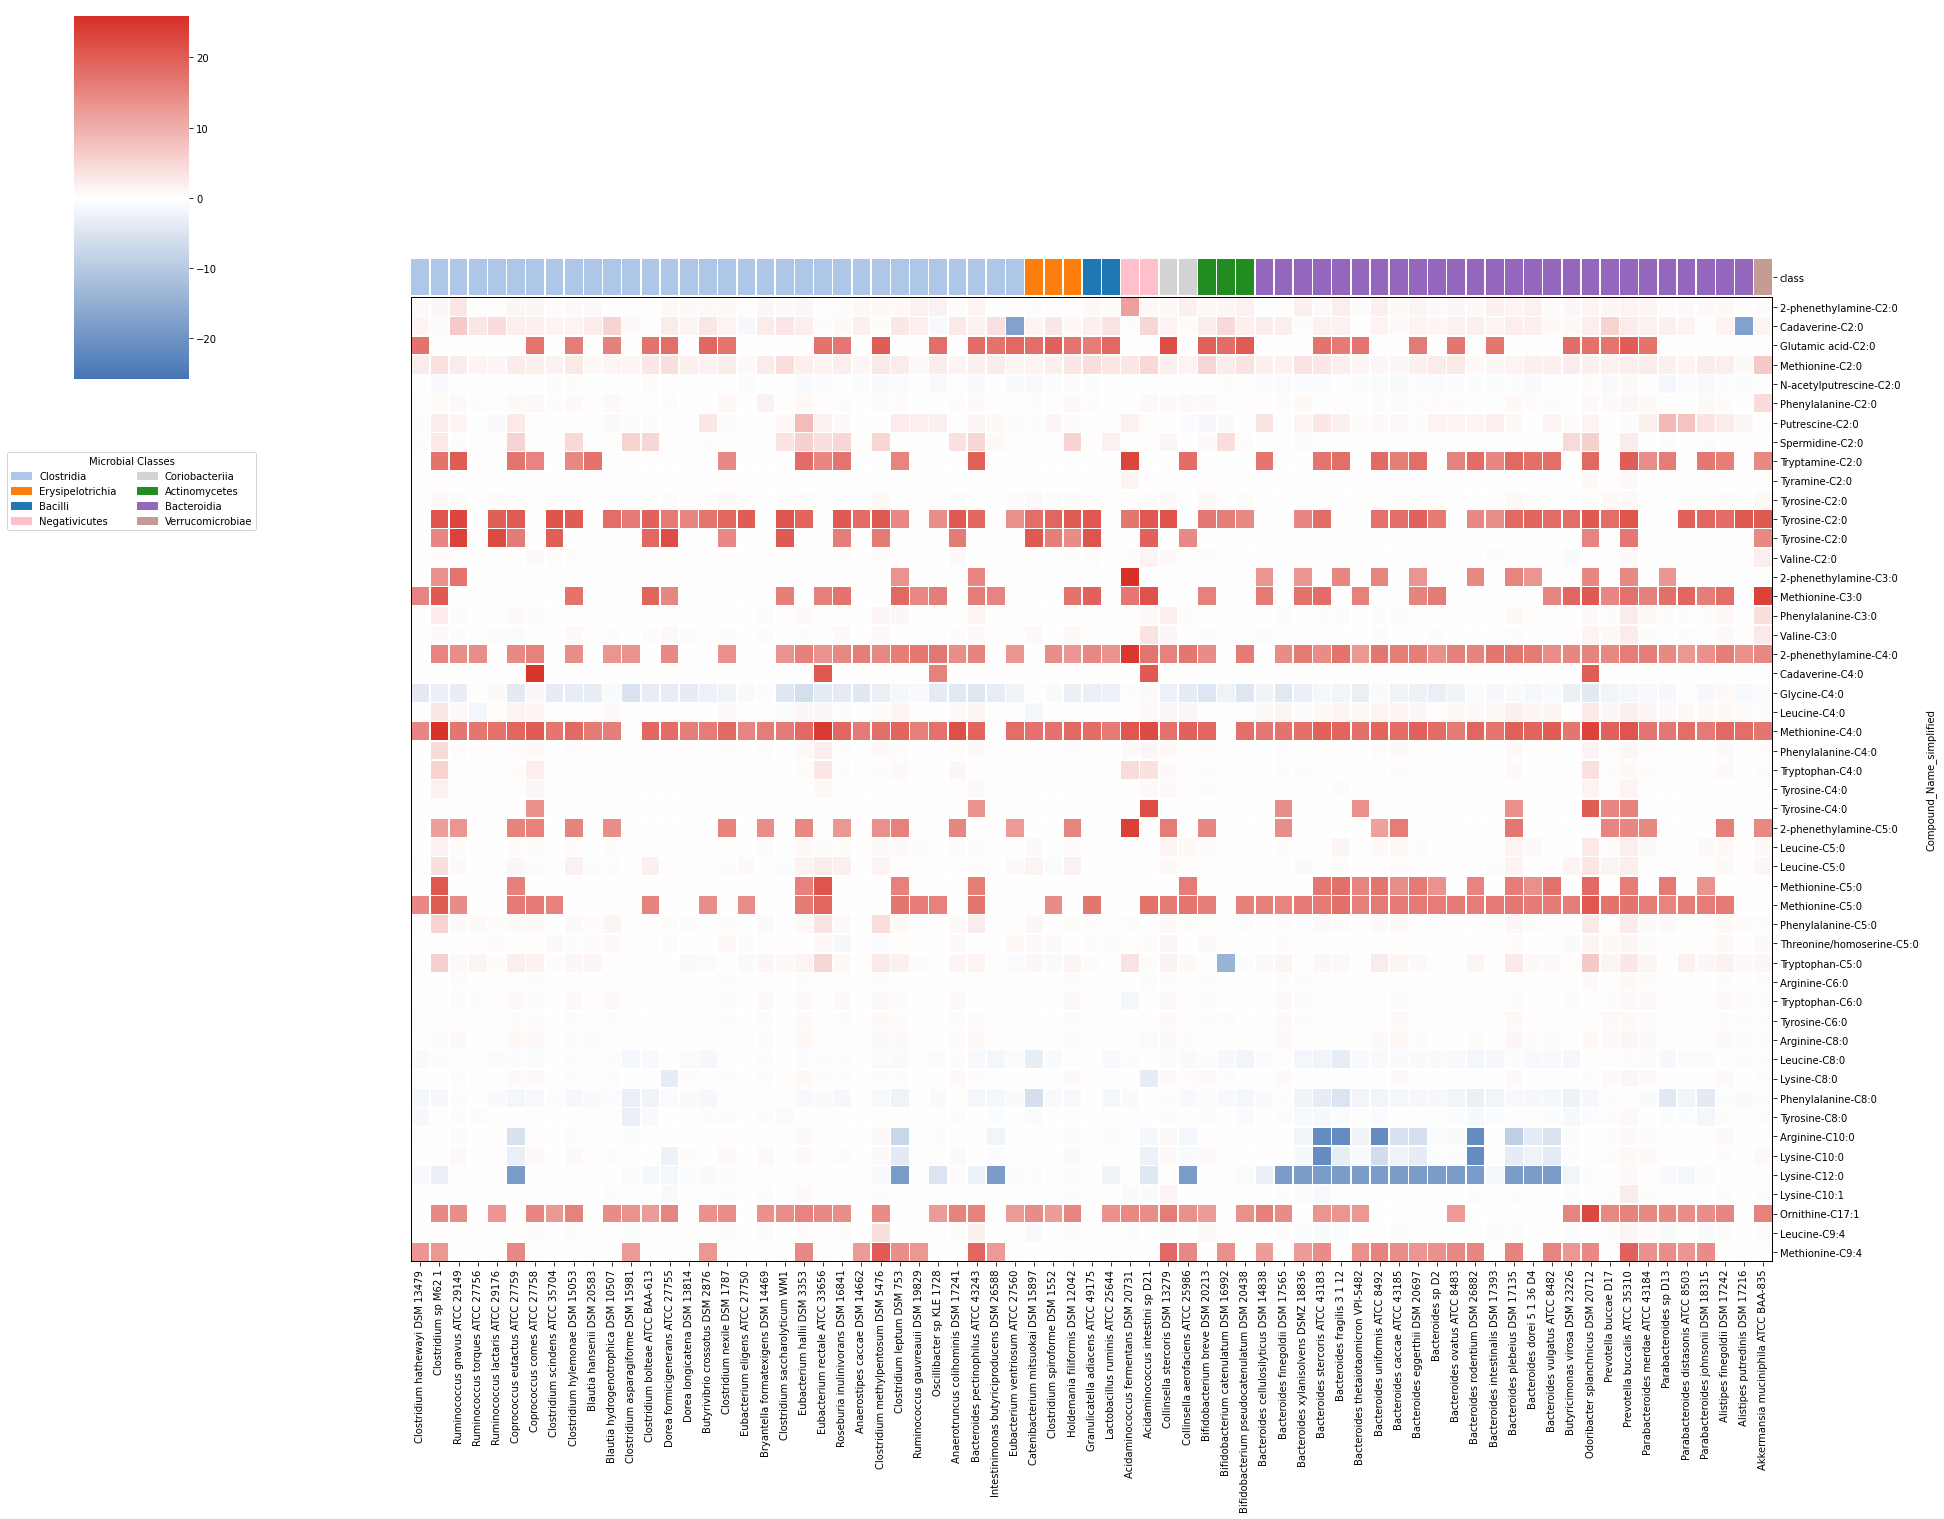

In [14]:
#plot
plt.figure(figsize=(15, 12))

max_abs_value = max(df_pivoted.max().max(), abs(df_pivoted.min().min()))

fig = sns.clustermap(
    df_pivoted, 
    cmap=divergent_cmap,
    metric = 'braycurtis',
    col_cluster=False, 
    row_cluster=False,
    linewidths=0.5,
    linecolor = 'white',
    xticklabels=1,
    yticklabels=True,
    cbar_kws={'orientation': 'vertical'},
    vmin=-max_abs_value,
    vmax=max_abs_value,
    col_colors=col_colors
)

line_count = len(df_pivoted.index)
fig.ax_heatmap.axhline(y=line_count, color='black', linewidth=2.0)
fig.ax_heatmap.axhline(y=0, color='black', linewidth=2.0)
fig.ax_heatmap.axvline(x=0, color='black', linewidth=2.0)
fig.ax_heatmap.axvline(x=len(df_pivoted.columns), color='black', linewidth=2.0)

# Add the legend
handles = [mpatches.Patch(color=class_color_mapping[cls], label=cls) for cls in unique_classes]
plt.legend(handles=handles, title='Microbial Classes', bbox_to_anchor=(0.5, -0.2), loc='upper center', borderaxespad=0., ncol=2)

plt.gcf().set_size_inches(32, 28)

plt.savefig('/.../Supplementary_Figure_3f.pdf')
plt.show()
